#### Color_Deconvolution Pipeline for pathology_png file

Colour deconvolution is a method used to transform colour images of multiple stained biological samples into images representing the stain concentrations. 

It is applied by decomposing the absorbance values of stain mixtures into absorbance values of single stains.

In [1]:
from __future__ import print_function

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

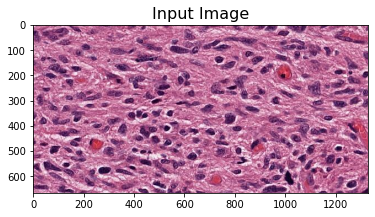

In [2]:
inputImageFile = ('https://data.kitware.com/api/v1/file/'
                  '57802ac38d777f12682731a2/download')  # H&E.png

imInput = skimage.io.imread(inputImageFile)[:, :, :3]

plt.imshow(imInput)
_ = plt.title('Input Image', fontsize=16)

### Supervised color deconvolution with a known stain matrix

stain_color_map:
{'hematoxylin': [0.65, 0.7, 0.29], 'eosin': [0.07, 0.99, 0.11], 'dab': [0.27, 0.57, 0.78], 'null': [0.0, 0.0, 0.0]}


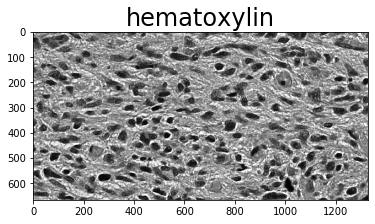

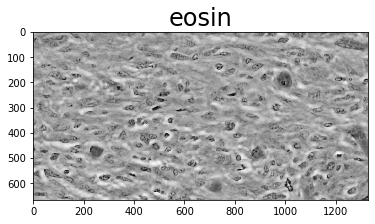

In [3]:
# create stain to color map
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
print('stain_color_map:', stain_color_map, sep='\n')

# specify stains of input image
stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains

# create stain matrix
W = np.array([stain_color_map[st] for st in stains]).T

# perform standard color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

### Unsupervised color deconvolution

Sparse Non-negative Matrix Factorization (SNMF) to estimate the stain vectors based on an initial guess

/home/raja/kmit/research/pathomics/pathomics/lib/python3.6/site-packages/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)
/home/raja/kmit/research/pathomics/pathomics/lib/python3.6/site-packages/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


Estimated stain colors (in rows):
[[0.48031803 0.78512115 0.39099791]
 [0.18892848 0.81830444 0.54284792]]


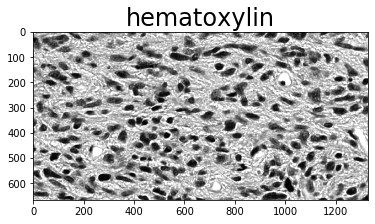

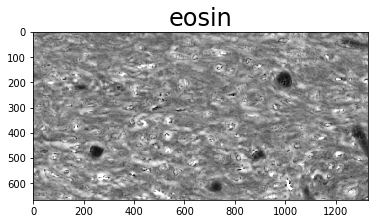

In [4]:
# create initial stain matrix
W_init = W[:, :2]

# Compute stain matrix adaptively
sparsity_factor = 0.5

I_0 = 255
im_sda = htk.preprocessing.color_conversion.rgb_to_sda(imInput, I_0)
W_est = htk.preprocessing.color_deconvolution.separate_stains_xu_snmf(
    im_sda, W_init, sparsity_factor,
)

# perform sparse color deconvolution
imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(
    imInput,
    htk.preprocessing.color_deconvolution.complement_stain_matrix(W_est),
    I_0,
)

print('Estimated stain colors (in rows):', W_est.T, sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    plt.imshow(imDeconvolved.Stains[:, :, i])
    _ = plt.title(stains[i], fontsize=titlesize)

### The PCA-based method of Macenko et al.

The PCA-based routine, unlike the SNMF-based one, does not require an initial guess, and instead automatically determines the vectors of a two-stain image

References

1. Van Eycke, Y. R., Allard, J., Salmon, I., Debeir, O., & Decaestecker, C. (2017). Image processing in digital pathology: an opportunity to solve inter-batch variability of immunohistochemical staining. Scientific Reports, 7.

2. Macenko, M., Niethammer, M., Marron, J. S., Borland, D., Woosley, J. T., Guan, X., … & Thomas, N. E. (2009, June). A method for normalizing histology slides for quantitative analysis. In Biomedical Imaging: From Nano to Macro, 2009. ISBI’09. IEEE International Symposium on (pp. 1107-1110). IEEE.

Estimated stain colors (rows):
[[0.16235564 0.81736416 0.55277164]
 [0.46329113 0.78963352 0.40229373]]


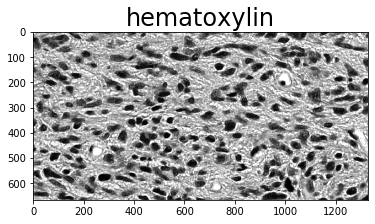

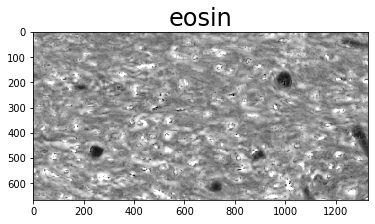

In [5]:
w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imInput, I_0)

# Perform color deconvolution
deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est, I_0)

print('Estimated stain colors (rows):', w_est.T[:2], sep='\n')

# Display results
for i in 0, 1:
    plt.figure()
    # Unlike SNMF, we're not guaranteed the order of the different stains.
    # find_stain_index guesses which one we want
    channel = htk.preprocessing.color_deconvolution.find_stain_index(
        stain_color_map[stains[i]], w_est)
    plt.imshow(deconv_result.Stains[:, :, channel])
    _ = plt.title(stains[i], fontsize=titlesize)